<a href="https://colab.research.google.com/github/Sehastrajit-clg/Deep-Learning/blob/main/DL_Lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ALEX NET 21BAI1303

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(1.0,))])


In [4]:
train = dset.MNIST(root='./data',train=True,transform=trans,download=True)
test = dset.MNIST(root='./data',train=False,transform=trans)

100%|██████████| 9912422/9912422 [00:00<00:00, 103895641.94it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 91285375.90it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49944691.64it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17938351.01it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
batch_size=32

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test,batch_size=batch_size,shuffle=False)

In [7]:
class AlexNet(nn.Module):
  def __init__(self,num=10):
    super(AlexNet,self).__init__()
    self.feature = nn.Sequential(
        nn.Conv2d(1,32,kernel_size=5,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(32,64,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(64,96,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(96,64,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64,32,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=1)
    )
    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(32*12*12,2048),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(2048,1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024,num),
    )

  def forward(self,x):
    x = self.feature(x);
    x = x.view(-1,32*12*12)
    x = self.classifier(x)
    return x

In [8]:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [9]:
def train(model,data_loader,loss_fn,optimizer,accuracy_fn,train_losses,train_accuracy,device=device):
  model.to(device)
  model.train()
  train_loss,train_acc=0,0
  for batch, (X,y) in enumerate(data_loader):
    X,y = X.to(device),y.to(device)
    optimizer.zero_grad()
    y_pred =  model(X)
    loss = loss_fn(y_pred,y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  train_losses.append(train_loss)
  train_accuracy.append(train_acc)
  print(f"Train Loss : {train_loss:.5f} | Train accuracy : {train_acc : .2f}%")

In [10]:
def test(model,data_loader,loss_fn,optimizer,accuracy_fn,test_losses,test_accuracy,device=device):
  model.to(device)
  model.eval()
  test_loss,test_acc = 0,0
  with torch.inference_mode():
    for X,y in data_loader:
      X,y =   X.to(device),y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred,y)
      test_loss += loss.item()
      test_acc+=accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))
  test_loss /= len(data_loader)
  test_acc /= len(data_loader)
  test_losses.append(test_loss)
  test_accuracy.append(test_acc)
  print(f"Test Loss : {test_loss:.5f} | test accuracy : {test_acc : .2f}%")

In [11]:
model = AlexNet()
print(model)
model.to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01)
loss_fn = nn.CrossEntropyLoss()

epochs = 10
train_losses=[]
train_accuracy=[]
test_losses=[]
test_accuracy=[]
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n......")
  train(model=model,data_loader = train_loader,loss_fn = loss_fn,optimizer = optimizer,accuracy_fn = accuracy_fn,train_losses = train_losses,train_accuracy = train_accuracy,device=device)
  test(model,test_loader,loss_fn,optimizer,accuracy_fn,test_losses,test_accuracy,device=device)

AlexNet(
  (feature): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU(in

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 0
......
Train Loss : 2.30142 | Train accuracy :  11.20%


 10%|█         | 1/10 [00:36<05:27, 36.42s/it]

Test Loss : 2.30066 | test accuracy :  11.35%
Epoch : 1
......
Train Loss : 2.30031 | Train accuracy :  11.24%


 20%|██        | 2/10 [01:02<04:01, 30.13s/it]

Test Loss : 2.29764 | test accuracy :  11.35%
Epoch : 2
......
Train Loss : 1.56831 | Train accuracy :  43.57%


 30%|███       | 3/10 [01:30<03:26, 29.43s/it]

Test Loss : 0.23732 | test accuracy :  92.83%
Epoch : 3
......
Train Loss : 0.20522 | Train accuracy :  93.44%


 40%|████      | 4/10 [01:56<02:47, 27.92s/it]

Test Loss : 0.08843 | test accuracy :  96.93%
Epoch : 4
......
Train Loss : 0.11861 | Train accuracy :  96.22%


 50%|█████     | 5/10 [02:21<02:15, 27.04s/it]

Test Loss : 0.05469 | test accuracy :  98.02%
Epoch : 5
......
Train Loss : 0.08993 | Train accuracy :  97.20%


 60%|██████    | 6/10 [02:47<01:46, 26.66s/it]

Test Loss : 0.04943 | test accuracy :  98.30%
Epoch : 6
......
Train Loss : 0.07326 | Train accuracy :  97.67%


 70%|███████   | 7/10 [03:16<01:21, 27.25s/it]

Test Loss : 0.03875 | test accuracy :  98.66%
Epoch : 7
......
Train Loss : 0.06518 | Train accuracy :  97.98%


 80%|████████  | 8/10 [03:41<00:53, 26.73s/it]

Test Loss : 0.03574 | test accuracy :  98.79%
Epoch : 8
......
Train Loss : 0.05700 | Train accuracy :  98.17%


 90%|█████████ | 9/10 [04:07<00:26, 26.44s/it]

Test Loss : 0.03174 | test accuracy :  98.86%
Epoch : 9
......
Train Loss : 0.05274 | Train accuracy :  98.28%


100%|██████████| 10/10 [04:33<00:00, 27.32s/it]

Test Loss : 0.03244 | test accuracy :  98.95%


#Visulaizing Plots


In [12]:
x = range(1,11)

In [13]:
x

range(1, 11)

## Train Loss

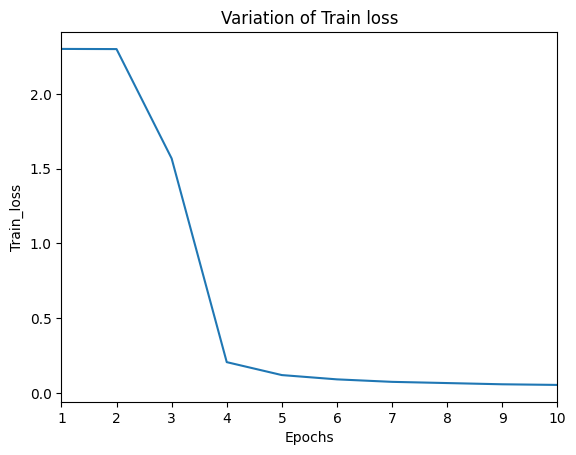

In [14]:
plt.xlabel("Epochs")
plt.ylabel("Train_loss")
plt.title("Variation of Train loss")
plt.xlim(1,10)
plt.plot(x,train_losses)
plt.show()

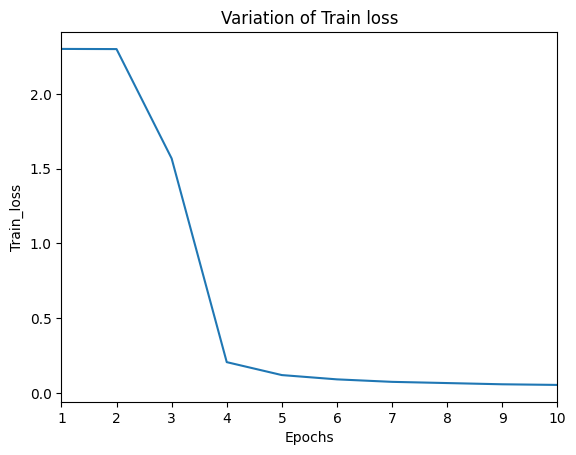

In [15]:
plt.xlabel("Epochs")
plt.ylabel("Train_loss")
plt.title("Variation of Train loss")
plt.xlim(1,10)
plt.plot(x,train_losses)
plt.show()

## Train Accuracy

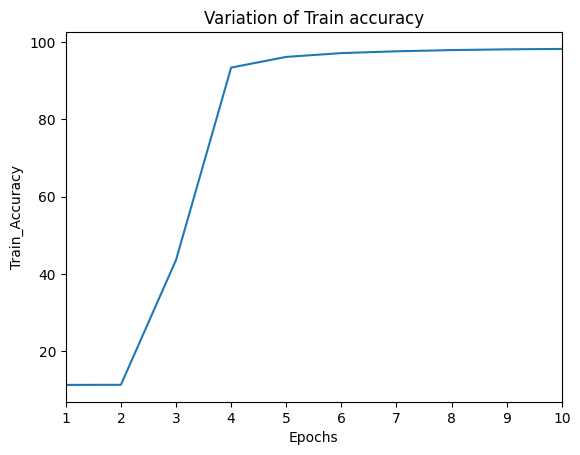

In [16]:
plt.xlabel("Epochs")
plt.ylabel("Train_Accuracy")
plt.title("Variation of Train accuracy")
plt.xlim(1,10)
plt.plot(x,train_accuracy)
plt.show()

## Test Loss

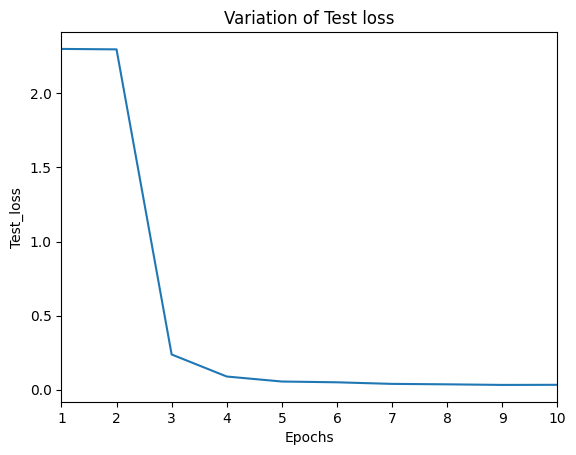

In [17]:
plt.xlabel("Epochs")
plt.ylabel("Test_loss")
plt.title("Variation of Test loss")
plt.xlim(1,10)
plt.plot(x,test_losses)
plt.show()

## Test Accuracy

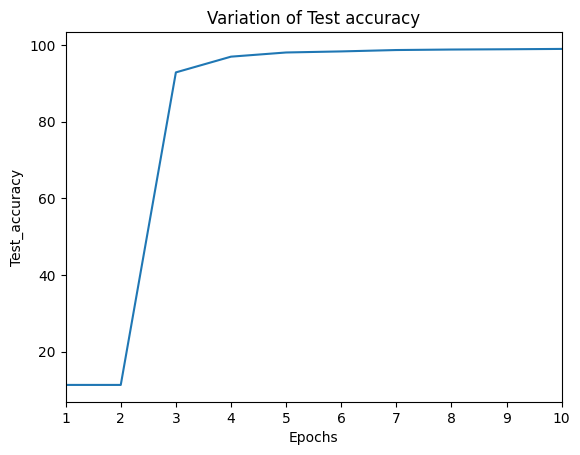

In [18]:
plt.xlabel("Epochs")
plt.ylabel("Test_accuracy")
plt.title("Variation of Test accuracy")
plt.xlim(1,10)
plt.plot(x,test_accuracy)
plt.show()

#CIFAR 10 Dataset


In [19]:
cifar_trainset = dset.CIFAR10(root='./data', train=True, download=True, transform=trans)

100%|██████████| 170498071/170498071 [00:03<00:00, 45189629.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [20]:
cifar_testset = dset.CIFAR10(root='./data', train=False, transform=trans)

In [21]:
class AlexNet_cifar(nn.Module):
  def __init__(self,num=10):
    super(AlexNet_cifar,self).__init__()
    self.feature = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=5,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(32,64,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(64,96,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(96,64,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64,32,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=1)
    )
    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(32*14*14,2048),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(2048,1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024,num),
    )

  def forward(self,x):
    x = self.feature(x);
    x = x.view(-1,32*14*14)
    x = self.classifier(x)
    return x

In [22]:
cifar_train_load = torch.utils.data.DataLoader(dataset=cifar_trainset,batch_size=32,shuffle=True)
cifar_test_load = torch.utils.data.DataLoader(dataset=cifar_testset,batch_size=32,shuffle=False)

In [ ]:
model = AlexNet_cifar()
print(model)
model.to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01)
loss_fn = nn.CrossEntropyLoss()

epochs = 10
train_losses=[]
train_accuracy=[]
test_losses=[]
test_accuracy=[]
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n......")
  train(model=model,data_loader = cifar_train_load,loss_fn = loss_fn,optimizer = optimizer,accuracy_fn = accuracy_fn,train_losses = train_losses,train_accuracy = train_accuracy,device=device)
  test(model,cifar_test_load,loss_fn,optimizer,accuracy_fn,test_losses,test_accuracy,device=device)

AlexNet_cifar(
  (feature): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): R

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 0
......
Train Loss : 2.30274 | Train accuracy :  9.74%


 10%|█         | 1/10 [00:26<03:54, 26.07s/it]

Test Loss : 2.30250 | test accuracy :  9.98%
Epoch : 1
......
Train Loss : 2.30256 | Train accuracy :  10.12%


 20%|██        | 2/10 [00:52<03:28, 26.04s/it]

Test Loss : 2.30215 | test accuracy :  15.20%
Epoch : 2
......
Train Loss : 2.30111 | Train accuracy :  12.14%


 30%|███       | 3/10 [01:17<03:01, 25.88s/it]

Test Loss : 2.29439 | test accuracy :  19.17%
Epoch : 3
......
Train Loss : 2.07996 | Train accuracy :  23.07%


 40%|████      | 4/10 [01:43<02:34, 25.82s/it]

Test Loss : 1.84885 | test accuracy :  32.12%
Epoch : 4
......
Train Loss : 1.81142 | Train accuracy :  31.81%


 50%|█████     | 5/10 [02:09<02:09, 25.81s/it]

Test Loss : 1.69613 | test accuracy :  36.12%
Epoch : 5
......


#Visulaizing Plots


In [ ]:
x = range(1,11)

In [ ]:
x

## Train Loss

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Train_loss")
plt.title("Variation of Train loss")
plt.xlim(1,10)
plt.plot(x,train_losses)
plt.show()

## Train Accuracy

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Train_Accuracy")
plt.title("Variation of Train accuracy")
plt.xlim(1,10)
plt.plot(x,train_accuracy)
plt.show()

## Test Loss

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Test_loss")
plt.title("Variation of Test loss")
plt.xlim(1,10)
plt.plot(x,test_losses)
plt.show()

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Test_accuracy")
plt.title("Variation of Test accuracy")
plt.xlim(1,10)
plt.plot(x,test_accuracy)
plt.show()